In [1]:
from networks.MPN import MPN_simplenet
from datasets.PowerFlowData import PowerFlowData
from torch_geometric.loader import DataLoader
from utils.explanation import explain_epoch
from utils.custom_loss_functions import Masked_L2_loss
import torch
import matplotlib.pyplot as plt
import networkx as nx

In [2]:

model = MPN_simplenet(
    nfeature_dim=16,
    efeature_dim=5,
    output_dim=6,
    hidden_dim=64,
    n_gnn_layers=2,
    K=3,
    dropout_rate=0.2
)
model.eval()
model.load_state_dict(torch.load('models/model_20230626-9920.pt')['model_state_dict'])
eval_loss_fn = Masked_L2_loss(regularize=False)
valset = PowerFlowData(root='data', case=118, split=[.5, .2, .3], task='val', undirected=True)
val_loader = DataLoader(valset, batch_size=1, shuffle=False)


TypeError: __init__() got an unexpected keyword argument 'undirected'

In [ ]:
means, stds, subgraph_nnodes, node_hop_data, nx_G = explain_epoch(model, val_loader, eval_loss_fn, 'cpu', samples=2)

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 3/50000 [00:04<19:24:53,  1.40s/it]


subgsize,nidx
694 	 65
697 	 107
704 	 79
742 	 110
742 	 111
749 	 104
749 	 101
781 	 100
781 	 102
783 	 106
797 	 109
799 	 103
830 	 99
833 	 105
862 	 95
868 	 96


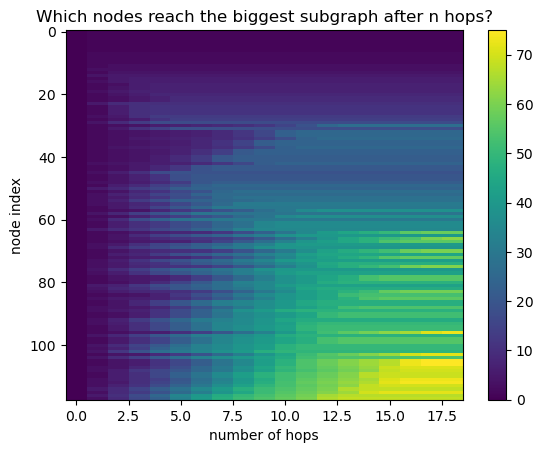

In [ ]:
sorted, indices = torch.sort(subgraph_nnodes[:,1:].sum(dim=1))

plt.title("Which nodes reach the biggest subgraph after n hops?")
plt.rcParams["figure.figsize"] = (10,5)
plt.imshow(subgraph_nnodes[indices], interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xlabel('number of hops')
plt.ylabel('node index')

# print worst ones
worst = [(int(x1), int(x2)) for x1, x2 in list(zip(subgraph_nnodes[:,1:].sum(dim=1)[indices], indices))]
print('subgsize,nidx')
[print(x[0], "\t", x[1]) for x in worst[-16:]]
pass


tensor([   nan, 0.5330, 0.4188, 0.3190, 0.2690, 0.2630, 0.2590, 0.2609, 0.2610,
        0.2592, 0.2505, 0.2605, 0.2588, 0.2540, 0.2505, 0.2570, 0.2622, 0.2597,
        0.2587])


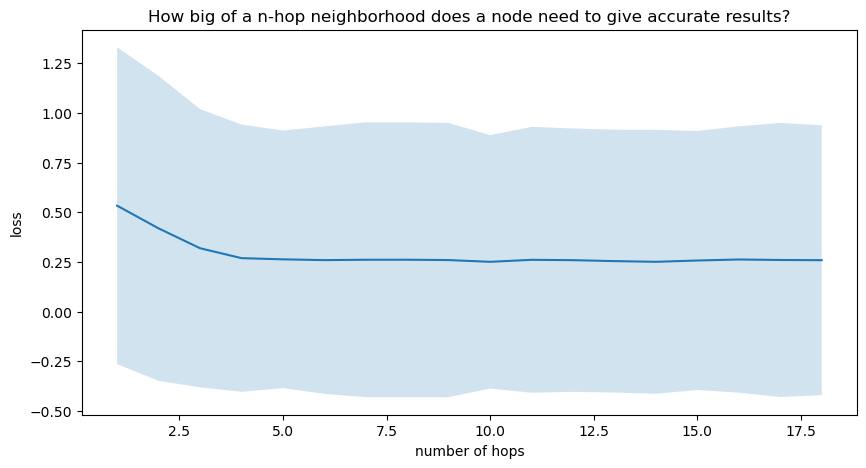

In [ ]:
plt.plot(range(means.shape[0]), means)
plt.fill_between(range(means.shape[0]), means - stds, means + stds, alpha=0.2)
plt.title("How big of a n-hop neighborhood does a node need to give accurate results?")
plt.xlabel('number of hops')
plt.ylabel('loss')
print(means)

loss,    nidx
6 	 21
7 	 28
7 	 1
7 	 10
8 	 58
9 	 47
9 	 81
9 	 52
9 	 59
10 	 82
14 	 67
14 	 83
60 	 63
60 	 62
74 	 37
74 	 80


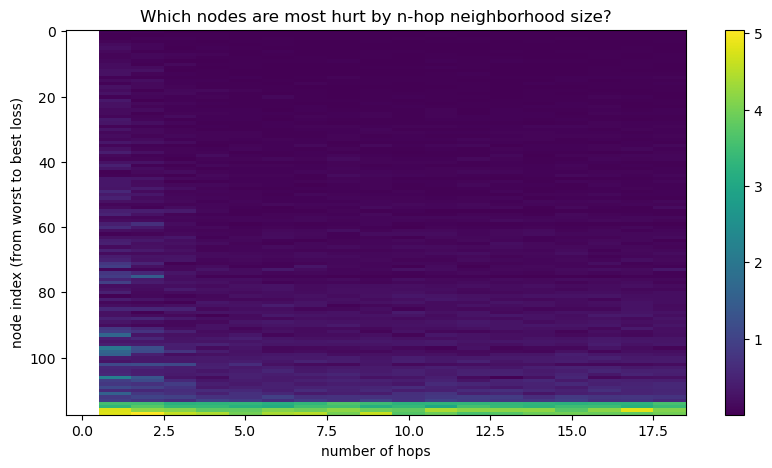

In [ ]:
sorted, indices = torch.sort(node_hop_data[:,1:].sum(dim=1))

plt.title("Which nodes are most hurt by n-hop neighborhood size?")
plt.rcParams["figure.figsize"] = (10,5)
plt.imshow(node_hop_data[indices], interpolation='nearest', aspect='auto')
plt.xlabel('number of hops')
plt.ylabel('node index (from worst to best loss)')
plt.colorbar()

# print worst ones
worst = [(int(x1), int(x2)) for x1, x2 in list(zip(node_hop_data[:,1:].sum(dim=1)[indices], indices))]
print('loss,    nidx')
[print(x[0], "\t", x[1]) for x in worst[-16:]]
pass

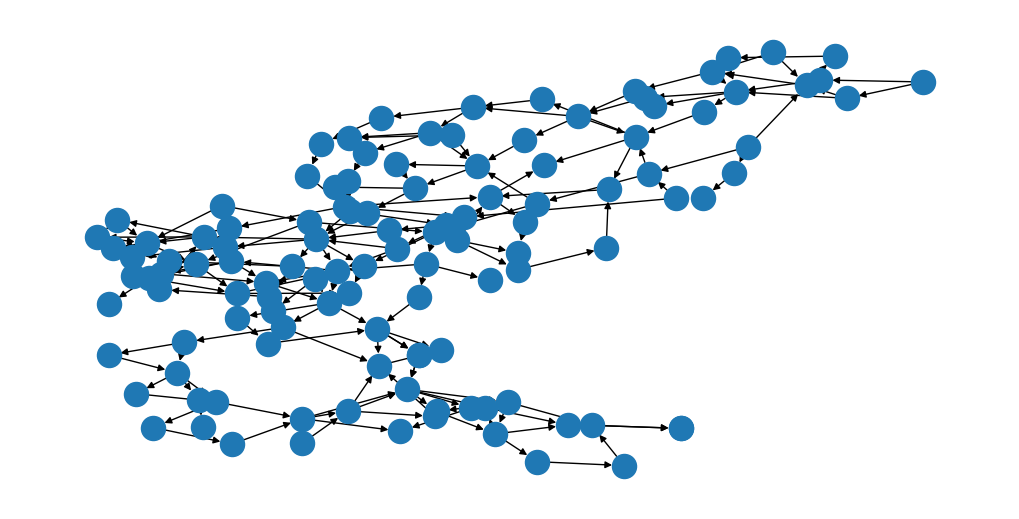

In [ ]:
nx.draw_kamada_kawai(nx_G)